In [1]:
## importing modules and loading the data
import numpy as np
import os
import nibabel as nib
import matplotlib as mlp
import MainFunctions as MF
import bokeh
import bokeh.plotting as bpl
from bokeh.models import ColorBar, BasicTicker, LinearColorMapper
import wav as wav
import matplotlib.pyplot as plt
# downloading the data
path0=os.getcwd()



In [2]:
# download the data if it doesnt exist. 
path=path0+'/content/bold5000/sub-CSI3_anat/sub-CSI3_ses-16_T1w.nii.gz'
downloaded=os.path.isfile(path)
if not downloaded:
    !pip install awscli
    os.chdir(path0)
    os.mkdir('./content')
    os.chdir('./content')
    os.mkdir('./bold5000')
    os.chdir(path0+'/content/bold5000')
    !aws s3 sync --no-sign-request s3://openneuro.org/ds001499/sub-CSI3/ses-16/anat/ ./sub-CSI3_anat/
    os.chdir(path0)
# load the data
data,hdr= MF.load_data()

In [3]:
# looking at a sample slice of the data
Nx = data.shape[0]
Ny = data.shape[1]
Nz = data.shape[2]
n = Ny
X = data[Nx//2, :, :];
bpl.output_notebook()
MF.imagesc(data[Nx//2, :, :], title='MR Image We Will Recover')

Loading BokehJS ...

Figure(id='1002', ...)

In [4]:
# create a remove map for random sampling:
import undersampling as us
prob=0.3
idxs=us.rmvMap_brn(prob, n,n)
print(idxs.shape)
print(n**2)

# getting the undersampled pictures:
levels=2
wave=wav.gen_wavelet()
S=wav.DWT(X,wave,levels)# the wavelet of signal
sz=S.shape[0]
#dummy, coeff_slices=wav.DWT(np.zeros((sz, sz)), wave, levels)
#check=wav.iDWT(S, wave,levels, coeff_slices)
Y = MF.meas_fun(S,idxs,levels)#np.abs(MF.measure_map(S, idxs, wave,levels, coeff_slices)) # takes idwt and does fft and undersamples. so Y is the undersampled pictures
# out of which we should reconstruct the original picture X.
#print(np.sum(np.abs(check)-X))

(45705, 2)
65536


In [5]:
print(S)

[[-3.94790260e-01 -1.95220264e-01 -1.76185077e-06 ...  5.58588758e-02
   1.10212386e-01 -3.25259825e-02]
 [ 1.66821530e+00  7.67648154e-01  7.97845517e-06 ... -2.55117703e-01
  -1.46641161e+00  4.43106636e-01]
 [ 2.41546959e+00  1.69290551e+00 -4.57144427e-05 ...  2.81545985e-01
  -1.27939509e+00  3.72550704e-01]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.46752608e-01  0.00000000e+00  0.00000000e+00 ...  4.17150282e-02
   4.16905977e-01 -1.26267496e-01]
 [-1.20421543e+00  0.00000000e+00  0.00000000e+00 ... -2.11896068e-01
   8.60062381e-01 -2.67459249e-01]]


In [6]:
# Getting the shape of our desired matrix
[p, q] = Y.shape
Y_frob = np.linalg.norm(Y, ord='fro')
Y_scaled = Y / Y_frob
sigma = np.std(Y_scaled)
S = np.random.normal(0, sigma, [p, q])
er=[]
# Creating an initial guess for S

# Initializing the regularizer
lambd = 1e-2
eps = 1e-4
itr= 50000
loss_value, S= MF.loss_prox2(S, Y, lambd,eps,Y_frob,idxs,levels,itr )


Loading BokehJS ...

30756930889.836605


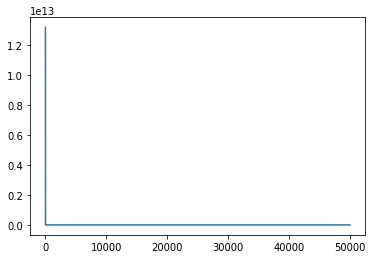

In [7]:
X_new = np.abs(Y_frob*wav.iDWT(S, wave,levels))

er.append(np.linalg.norm(X_new - X, ord='fro'))

bpl.output_notebook()
MF.imagesc(np.abs(X_new), title = 'P = '+str(prob))
plt.plot(loss_value)
print(np.sum(np.abs(S)))